# Dataset split train and test with timeseries generator

## Import libraries

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D 
from keras.callbacks import ModelCheckpoint

from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

Notebook running on Python 3.8.3
Numpy version 1.18.1
Keras version  2.3.1 and TensorFlow 2.2.0 (CUDA: True - GPUs available: ['/device:GPU:0'] )


## Define global variables
Such as object dimension and dataset properties

In [3]:
dimX, dimY, dimZ = 117, 86, 38
n_cells = dimX * dimY * dimZ
dims = (dimX, dimY, dimZ)
n_channels = 3
n_input = 3
n_output = 10
n_batch = 8
leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

In [4]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_datasets, batch_size=128, dim=(32,32,32), n_channels=3, shuffle=True, observation_samples=3, multistep=1):
        #print('Generator Initialization')
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.n_input = observation_samples      
        self.n_output = multistep
        self.last_samples = self.n_input - 1 + self.n_output      
        
        self.indexes = []
        cnt = 0
        self.total_samples = 0
        for case in list_datasets:
            samples = len(case) - self.last_samples
            self.total_samples += samples
            for sample in range(samples):
                self.indexes.append(cnt)
                cnt += 1
            cnt += self.last_samples
        
        self.ds = np.concatenate((list_datasets), axis = 0)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.total_samples / self.batch_size))
  
    def __getitem__(self, batch_index):          
        'Generate one batch of data through dataset'
        list_IDs_temp = self.indexes[batch_index * self.batch_size : (batch_index+1) * self.batch_size]
        #print(index, list_IDs_temp)
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        #print('Yieded batch %d' % index)
        return X, y

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels * self.n_input))
        y = np.empty((self.batch_size, *self.dim, self.n_channels * self.n_output))
        
        for i, ID in enumerate(list_IDs_temp):  
            inFrom = ID
            inTo = inFrom + self.n_input
            outFrom = inTo
            outTo = outFrom + self.n_output
            
            X[i] = np.concatenate((self.ds[inFrom : inTo]), axis = 3)
            y[i] = np.concatenate((self.ds[outFrom : outTo]), axis = 3)
        return X, y

## Load data from files
Data is filtered and reshaped for scaling.
First 200 samples are kept, while the rest of them are thirded.


In [5]:
%%time
samples_per_case = []
ds = []
path = "/scratch/siserte/ainaV2/"
filelist = [path + "case1.npz", path + "case2.npz", path + "case3.npz"]
#filelist = [path + "case3.npz"]
for filename in filelist:
        print(filename)
        dsaux = np.load(filename)
        dsaux = dsaux.f.data
        if filename == "/scratch/siserte/ainaV2/case1.npz" or filename == "/scratch/siserte/ainaV2/case3.npz":
            dsaux = np.concatenate((dsaux[:700], dsaux[700::2]), axis=0)
        else:
            dsaux = dsaux[::2]
        print(dsaux.shape)
        samples_per_case.append(len(dsaux))
        ds.append(dsaux.reshape(dsaux.shape[0] * dsaux.shape[1] * dsaux.shape[2] * dsaux.shape[3], dsaux.shape[4]))
        print(ds[-1].shape)
ds = np.array(ds)
ds = np.concatenate(ds, axis=0)

/scratch/siserte/ainaV2/case1.npz
(1256, 117, 86, 38, 3)
(480239136, 3)
/scratch/siserte/ainaV2/case2.npz


KeyboardInterrupt: 

In [6]:
path += "CNN-multistep-2"

In [7]:
print('Dataset size in memory: %0.2f GB' % (ds.nbytes / 1024**3))
np.info(ds)

AttributeError: 'list' object has no attribute 'nbytes'

### jump to load model if already trained 

## Normalize X, Y, Z separatedly and reshape it for the generator
We have used StandardScaler from Sklearn, which normalize with a 2D dataset (value - mean) / std -> https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [7]:
print(ds.shape)
dsX = ds[:, 0]
dsX = dsX.reshape((-1, n_cells))
dsY = ds[:, 1]
dsY = dsY.reshape((-1, n_cells))
dsZ = ds[:, 2]
dsZ = dsZ.reshape((-1, n_cells))
print(dsX.shape)

(769300272, 3)
(2012, 382356)


In [8]:
print("Range test dataset X [%0.2f:%0.2f]" % (np.min(dsX), np.max(dsX)))
print("Range test dataset Y [%0.2f:%0.2f]" % (np.min(dsY), np.max(dsY)))
print("Range test dataset Z [%0.2f:%0.2f]" % (np.min(dsZ), np.max(dsZ)))

Range test dataset X [-7.67:12.49]
Range test dataset Y [-7.86:7.86]
Range test dataset Z [-4.59:6.63]


In [9]:
%%time
scalerX = StandardScaler(copy=False)
scalerX.fit_transform(dsX)
dsX = dsX.reshape(sum(samples_per_case), dimX, dimY, dimZ, 1)
print(samples_per_case)
acc = 0
dsX_ready = []
for case in range(len(samples_per_case)):
    idx_ini = acc
    acc += samples_per_case[case]
    dsX_ready.append(dsX[idx_ini:acc, :, :, :, :])  
dsX_ready=np.array(dsX_ready)


[906, 404, 702]
CPU times: user 13.4 s, sys: 2.16 s, total: 15.5 s
Wall time: 15.5 s


In [10]:
%%time
scalerY = StandardScaler(copy=False)
scalerY.fit_transform(dsY)
dsY = dsY.reshape(sum(samples_per_case), dimX, dimY, dimZ, 1)
print(samples_per_case)
acc = 0
dsY_ready = []
for case in range(len(samples_per_case)):
    idx_ini = acc
    acc += samples_per_case[case]
    dsY_ready.append(dsY[idx_ini:acc, :, :, :, :])  
dsY_ready=np.array(dsY_ready)

[906, 404, 702]
CPU times: user 13.3 s, sys: 2.13 s, total: 15.5 s
Wall time: 15.5 s


In [11]:
%%time
scalerZ = StandardScaler(copy=False)
scalerZ.fit_transform(dsZ)
dsZ = dsZ.reshape(sum(samples_per_case), dimX, dimY, dimZ, 1)
print(samples_per_case)
acc = 0
dsZ_ready = []
for case in range(len(samples_per_case)):
    idx_ini = acc
    acc += samples_per_case[case]
    dsZ_ready.append(dsZ[idx_ini:acc, :, :, :, :])  
dsZ_ready=np.array(dsZ_ready)

[906, 404, 702]
CPU times: user 13.2 s, sys: 1.78 s, total: 15 s
Wall time: 14.9 s


In [14]:
dump(scalerX, path + "/scalerX.joblib")
dump(scalerY, path + "/scalerY.joblib")
dump(scalerZ, path + "/scalerZ.joblib")

['/scratch/siserte/ainaV2/CNN-multistep/scalerZ.joblib']

In [15]:
%%time
#print(dsX_ready.shape, dsY_ready.shape, dsZ_ready.shape)
#print(dsX_ready[0].shape, dsY_ready[0].shape, dsZ_ready[0].shape)
ds_ready = []
for i in range(dsX_ready.shape[0]):
    ds_ready.append(np.concatenate((dsX_ready[i], dsY_ready[i], dsZ_ready[i]), axis=4))
ds_ready = np.array(ds_ready)

#print(ds_ready.shape)
#for i in range(ds_ready.shape[0]):
#    print(ds_ready[i].shape)

CPU times: user 4.04 s, sys: 5.51 s, total: 9.55 s
Wall time: 9.56 s


In [16]:
del ds, dsaux, dsX, dsY, dsZ, dsX_ready, dsY_ready, dsZ_ready
gc.collect()

100

In [17]:
#np.save(path + "dataset.scaled", ds_ready)
#pickle.dump(scaler, open(path + "dataset.scaler", "w"), protocol=4)

In [18]:
np.info(ds_ready)

class:  ndarray
shape:  (3,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x55b79b52ed40
byteorder:  little
byteswap:  False
type: object


## Define the ML model

In [19]:
mirrored_strategy = tf.distribute.MirroredStrategy() #devices=['/job:localhost/replica:0/task:0/device:GPU:1']
with mirrored_strategy.scope():
    model = Sequential()
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same", data_format="channels_last", input_shape=(dimX, dimY, dimZ, n_channels * n_input)))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    model.add(Conv3D(256, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation=leakyrelu, padding="same"))
    model.add(Conv3D(n_channels * n_output, kernel_size=(3, 3, 3), activation='linear', padding="same"))

model.compile(loss='mse', optimizer='adam')#, metrics=[rmse, 'mae'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 117, 86, 38, 64)   15616     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 117, 86, 38, 128)  221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 117, 86, 38, 256)  884992    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 117, 86, 38, 128)  884864    
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 117, 86, 38, 64)   221248    
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 117, 86, 38, 30)   51870     
Total params: 2,27

## Training

In [20]:
train = DataGenerator(ds_ready[:2],
                      batch_size=n_batch, dim=dims, n_channels=n_channels, shuffle=True, observation_samples=n_input, multistep=n_output)
n_epochs=1000

In [21]:
%%time
filepath= path + "/train-{epoch:02d}-{loss:.2f}.hdf5"
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.00001, verbose=1, restore_best_weights = True)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
callbacks_list = [earlystop, checkpoint]

H = model.fit_generator(train, epochs=n_epochs, verbose=1, shuffle=True, callbacks=callbacks_list)

Epoch 1/1000
160/160 [==============================] - 671s 4s/step - loss: 0.1723

Epoch 00001: loss improved from inf to 0.17227, saving model to /scratch/siserte/ainaV2/CNN-multistep/train-01-0.17.hdf5
Epoch 2/1000
160/160 [==============================] - 636s 4s/step - loss: 0.0576

Epoch 00002: loss improved from 0.17227 to 0.05764, saving model to /scratch/siserte/ainaV2/CNN-multistep/train-02-0.06.hdf5
Epoch 3/1000
160/160 [==============================] - 636s 4s/step - loss: 0.0467

Epoch 00003: loss improved from 0.05764 to 0.04670, saving model to /scratch/siserte/ainaV2/CNN-multistep/train-03-0.05.hdf5
Epoch 4/1000
160/160 [==============================] - 635s 4s/step - loss: 0.0394

Epoch 00004: loss improved from 0.04670 to 0.03940, saving model to /scratch/siserte/ainaV2/CNN-multistep/train-04-0.04.hdf5
Epoch 5/1000
160/160 [==============================] - 635s 4s/step - loss: 0.0326

Epoch 00005: loss improved from 0.03940 to 0.03262, saving model to /scratch/si

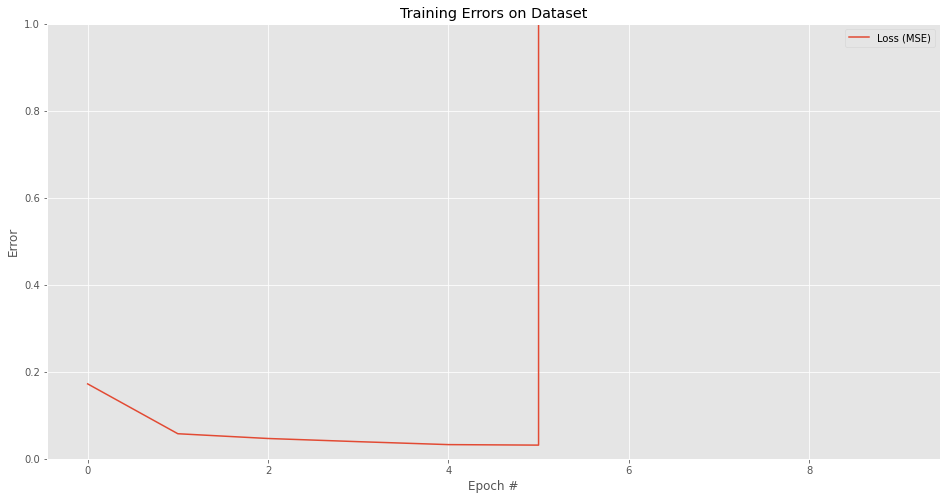

In [22]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
#plt.plot(np.arange(0, N), H.history["loss"], label="Loss (MSE)")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="Val Loss (MSE)")
plt.plot(H.history["loss"], label="Loss (MSE)")
#plt.plot(H.history["val_loss"], label="Val Loss (MSE)")
plt.title("Training Errors on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.legend()
plt.ylim(0,1)
#plt.savefig("plot.png")
plt.show()

In [23]:
model.save(path + "/model.h5")

In [ ]:
import os
os._exit(00)

In [ ]:
del train
gc.collect()



## Load model

In [7]:
model = load_model(path + "/model.h5", compile=True, custom_objects={'<lambda>': leakyrelu})
model.summary()
model.load_weights(path + "/train-06-0.03.hdf5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 117, 86, 38, 64)   15616     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 117, 86, 38, 128)  221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 117, 86, 38, 256)  884992    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 117, 86, 38, 128)  884864    
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 117, 86, 38, 64)   221248    
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 117, 86, 38, 30)   51870     
Total params: 2,279,902
Trainable params: 2,279,902
Non-trainable params: 0
____________________________________________

In [8]:
scalerX = load(path + '/scalerX.joblib')
scalerY = load(path + '/scalerY.joblib')
scalerZ = load(path + '/scalerZ.joblib')

In [9]:
print(ds.shape)
dsX = ds[:, 0]
dsX = dsX.reshape((-1, n_cells))
dsY = ds[:, 1]
dsY = dsY.reshape((-1, n_cells))
dsZ = ds[:, 2]
dsZ = dsZ.reshape((-1, n_cells))
print(dsX.shape)

(268413912, 3)
(702, 382356)


In [11]:
scalerX.fit_transform(dsX)
dsX = dsX.reshape(-1, dimX, dimY, dimZ, 1)
scalerY.fit_transform(dsY)
dsY = dsY.reshape(-1, dimX, dimY, dimZ, 1)
scalerZ.fit_transform(dsZ)
dsZ = dsZ.reshape(-1, dimX, dimY, dimZ, 1)

In [12]:
ds_test = np.concatenate((dsX, dsY, dsZ), axis=4)
ds_test.shape

(702, 117, 86, 38, 3)

In [ ]:
del ds, dsaux, dsX, dsY,dsZ, scalerX, scalerY, scalerZ
gc.collect()

## Evaluation

ds_test = ds_ready[2]
print(ds_test.shape)

In [13]:
print(np.expand_dims(ds_test, axis=0).shape)
print(ds_test.shape)
print(ds_test[:n_input].shape)
print(np.expand_dims(ds_test[:n_output], axis=0).shape)

(1, 702, 117, 86, 38, 3)
(702, 117, 86, 38, 3)
(3, 117, 86, 38, 3)
(1, 10, 117, 86, 38, 3)


In [15]:
%%time
n_batch = 1
results = []
n_evals = len(ds_test) - n_input - n_output
for offset in range(n_evals):
    samples = n_input + offset + n_output
    ini = offset
    end = samples
    #print("%d/%d Evaluate on test data (Input: %d:%d, Output: %d:%d)" % (offset, n_evals, ini, ini + n_input, ini + n_input, end))
    test = DataGenerator(np.expand_dims(ds_test[ini : end], axis=0), batch_size=n_batch, dim=dims, n_channels=n_channels, shuffle=False, observation_samples=n_input, multistep = n_output)
    results.append(model.evaluate(test, verbose=0))
    #print("Evaluate on test data: MSE: %.4f" % (results[offset]))

CPU times: user 2min 31s, sys: 1min 21s, total: 3min 53s
Wall time: 5min 3s


In [16]:
print("From %d samples: Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (len(results), Decimal(float(np.min(results))), Decimal(float(np.max(results))), 
       Decimal(float(np.mean(results))), Decimal(float(np.std(results)))))

From 689 samples: Min error: 1.42E-02, Max error: 8.24E-01, Mean error: 4.96E-02, Std error: 7.35E-02


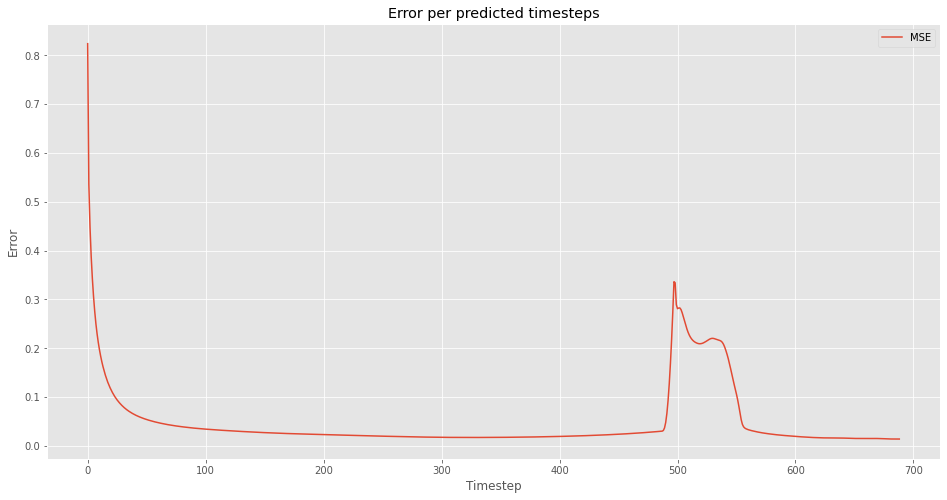

In [17]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
plt.plot(results, label="MSE")
plt.title("Error per predicted timesteps")
plt.xlabel("Timestep")
plt.ylabel("Error")
plt.legend()
#plt.ylim(0,1)
plt.show()

In [38]:
del test, results
del dsX, dsY, dsZ
gc.collect()

20

## Prediction

In [50]:
%%time
results = []
step = n_input + n_output
results = []
for offset in range(0, len(ds_test), step):
    test = ds_test[offset:offset + n_input]
    
    for i in range(len(test)):
        results.append(test[i])
    
    test = test.reshape((1,) + dims + (-1,))
    
    pred_output = model.predict(test, verbose=0)
    pred_output = np.array(pred_output)
    pred_output = pred_output.reshape((n_output,) + dims + (n_channels,))
    
    for i in range(len(pred_output)):
        results.append(pred_output[i])
        
pred_output = np.array(results)
print(pred_output.shape)

CPU times: user 9.24 s, sys: 8.01 s, total: 17.2 s
Wall time: 17.2 s


#test = DataGenerator(np.expand_dims(ds_test[0:13], axis=0), batch_size=1, dim=dims, n_channels=n_channels, shuffle=False, observation_samples=n_input, multistep = n_output)
test = ds_test[0:3]
test = test.reshape((1,) + dims + (-1,))
pred_output = model.predict(test, verbose=1)
pred_output = np.array(pred_output)
print(pred_output.shape)
pred_output = pred_output.reshape((n_output,) + dims + (n_channels,))
print(pred_output.shape)

## Inverse scaling of test and prediction dataset

In [53]:
test_output = ds_test
print(test_output.shape)
print(pred_output.shape)

(702, 117, 86, 38, 3)
(702, 117, 86, 38, 3)


In [54]:
mean_squared_error(test_output.reshape(-1,n_cells), pred_output.reshape(-1, n_cells))

1.5100533

In [55]:
dsX_test = test_output[:,:,:,:,0].reshape(-1, n_cells)
scalerX.inverse_transform(dsX_test)
dsX_pred = pred_output[:,:,:,:,0].reshape(-1, n_cells)
scalerX.inverse_transform(dsX_pred)

dsY_test = test_output[:,:,:,:,1].reshape(-1, n_cells)
scalerY.inverse_transform(dsY_test)
dsY_pred = pred_output[:,:,:,:,1].reshape(-1, n_cells)
scalerY.inverse_transform(dsY_pred)

dsZ_test = test_output[:,:,:,:,2].reshape(-1, n_cells)
scalerZ.inverse_transform(dsZ_test)
dsZ_pred = pred_output[:,:,:,:,2].reshape(-1, n_cells)
scalerZ.inverse_transform(dsZ_pred)

print(dsX_test.shape)
print(dsX_pred.shape)

(702, 382356)
(702, 382356)


## Error calculation per timestep and channel

In [56]:
print("Range test dataset X [%0.2f:%0.2f]" % (np.min(dsX_test), np.max(dsX_test)))
print("Range predicted dataset X [%0.2f:%0.2f]" % (np.min(dsX_pred), np.max(dsX_pred)))
mse = mean_squared_error(dsX_test, dsX_pred)
print("MSE: %.2E" % Decimal(float(mse)))
msesX = []
for ts in range(len(dsX_test)):
    tsX_test = dsX_test[ts]
    tsX_pred = dsX_pred[ts]
    #print(tsX_pred.shape)
    msesX.append(mean_squared_error(tsX_test, tsX_pred))
msesX = np.array(msesX)
#print(msesX.shape)
print("Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (Decimal(float(np.min(msesX))), Decimal(float(np.max(msesX))), 
       Decimal(float(np.mean(msesX))), Decimal(float(np.std(msesX)))))

Range test dataset X [-3.69:28.25]
Range predicted dataset X [-28.40:29.22]
MSE: 1.32E+00
Min error: 0.00E+00, Max error: 3.43E+01, Mean error: 1.32E+00, Std error: 2.75E+00


In [57]:
print("Range test dataset Y [%0.2f:%0.2f]" % (np.min(dsY_test), np.max(dsY_test)))
print("Range predicted dataset Y [%0.2f:%0.2f]" % (np.min(dsY_pred), np.max(dsY_pred)))
mse = mean_squared_error(dsY_test, dsY_pred)
print("MSE: %.2E" % Decimal(float(mse)))
msesY = []
for ts in range(len(dsY_test)):
    tsY_test = dsY_test[ts]
    tsY_pred = dsY_pred[ts]
    msesY.append(mean_squared_error(tsY_test, tsY_pred))
msesY = np.array(msesY)
print("Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (Decimal(float(np.min(msesY))), Decimal(float(np.max(msesY))), 
       Decimal(float(np.mean(msesY))), Decimal(float(np.std(msesY)))))

Range test dataset Y [-7.86:7.86]
Range predicted dataset Y [-20.77:21.15]
MSE: 1.86E-01
Min error: 0.00E+00, Max error: 2.24E+00, Mean error: 1.86E-01, Std error: 1.72E-01


In [58]:
print("Range test dataset Z [%0.2f:%0.2f]" % (np.min(dsZ_test), np.max(dsZ_test)))
print("Range predicted dataset Z [%0.2f:%0.2f]" % (np.min(dsZ_pred), np.max(dsZ_pred)))
mse = mean_squared_error(dsZ_test, dsZ_pred)
print("MSE: %.2E" % Decimal(float(mse)))
msesZ = []
for ts in range(len(dsZ_test)):
    tsZ_test = dsZ_test[ts]
    tsZ_pred = dsZ_pred[ts]
    msesZ.append(mean_squared_error(tsZ_test, tsZ_pred))
msesZ = np.array(msesZ)
print("Min error: %.2E, Max error: %.2E, Mean error: %.2E, Std error: %.2E" % 
      (Decimal(float(np.min(msesZ))), Decimal(float(np.max(msesZ))), 
       Decimal(float(np.mean(msesZ))), Decimal(float(np.std(msesZ)))))

Range test dataset Z [-3.10:4.80]
Range predicted dataset Z [-9.87:20.18]
MSE: 1.18E-01
Min error: 0.00E+00, Max error: 1.39E+00, Mean error: 1.18E-01, Std error: 1.18E-01


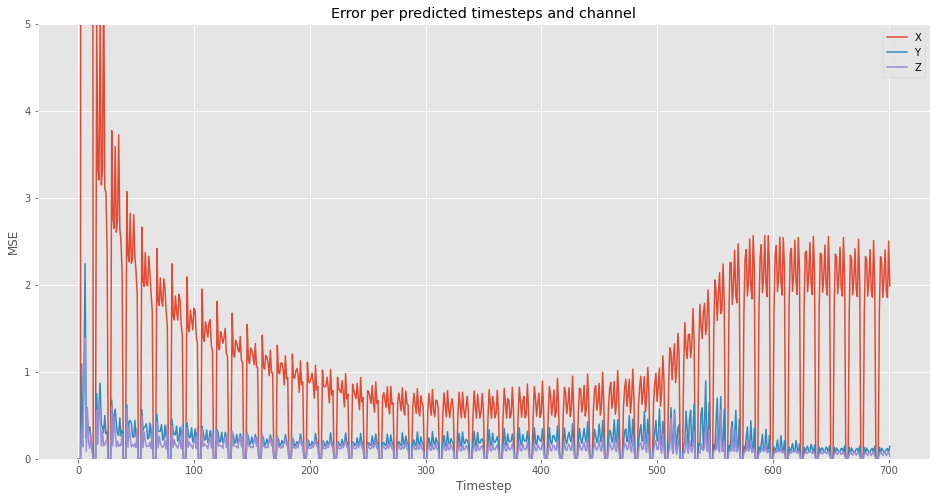

In [60]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
plt.plot(msesX, label="X")
plt.plot(msesY, label="Y")
plt.plot(msesZ, label="Z")
plt.title("Error per predicted timesteps and channel")
plt.xlabel("Timestep")
plt.ylabel("MSE")
plt.legend()
plt.ylim(0,5)
plt.show()

In [ ]:
import os
os._exit(00)

## Prediction vs Expected

In [51]:
y_test = test_output.reshape(-1, n_cells, n_channels)
y_pred = pred_output.reshape(-1, n_cells, n_channels)

In [ ]:
np.random.seed(0)
#probesPositionArray = np.concatenate((np.arange(0, 10), np.random.randint(0, flat, 10)), axis=None)
probesPositionArray = np.arange(0, 20)
metrics = ["X", "Y", "Z"]
for probe in probesPositionArray:
    values1=[]
    values2=[]
    for i in range(len(y_pred)):
        values1.append(y_test[i][probe])
        values2.append(y_pred[i][probe])
    values1 = np.array(values1)
    values2 = np.array(values2)
    
    x = probe % dimX
    y = int((probe/dimX) % dimY)
    z = int((probe/dimX/dimY) % dimZ)

    str = "Velocity (x,y,z) at point: (%d, %d, %d) - MSE: (" % (x, y, z)
    for i in range(len(metrics)):
        mse = mean_squared_error(values1[:, i], values2[:, i])
        str += "%.2E, " % Decimal(float(mse))
    str = str[:-2]
    str += ")"
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(str)
    ax1.plot(values1[:, 0])
    ax1.plot(values2[:, 0])
    ax2.plot(values1[:, 1])
    ax2.plot(values2[:, 1])
    ax3.plot(values1[:, 2])
    ax3.plot(values2[:, 2])
    plt.legend(['Test', 'Prediction'])
    plt.xlabel('Timesteps')
    plt.show()
    
